<a href="https://colab.research.google.com/github/DJuic3/supreme-system/blob/master/Copy_of_LC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pydicom


     |████████████████████████████████| 2.0 MB 27.0 MB/s 


In [8]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndimage

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Some constants 
INPUT_FOLDER = '/content/drive/MyDrive/lungcancer/Dataset_LUNA_16/subset_0'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(len(patients))
#patients.remove('.DS_Store')

2


In [11]:
def load_scan(path):
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force = True) for s in ds]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [18]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

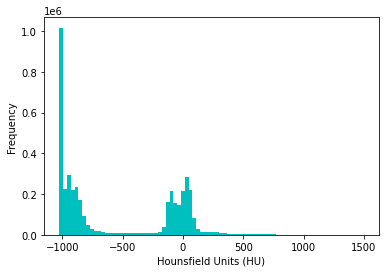

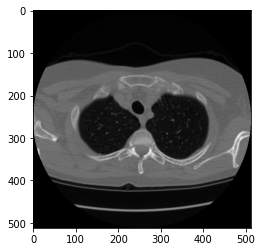

(0.0, 1.0, 0.0, 1.0)

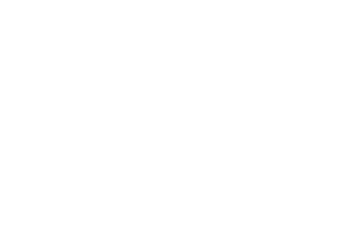

In [24]:
first_patient = load_scan(INPUT_FOLDER +'/'+ patients[1])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[1], cmap=plt.cm.gray)
plt.show()
plt.axis('off')

In [25]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [26]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (16, 512, 512)
Shape after resampling	 (360, 306, 306)


In [27]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces,_,_ = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    return plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  


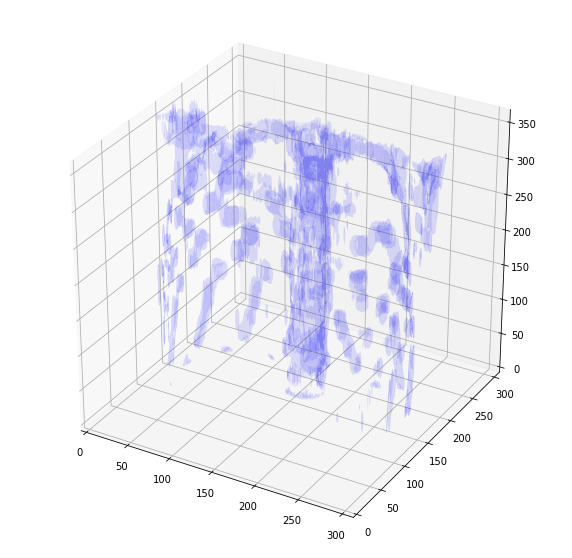

In [28]:
plot_3d(pix_resampled, 400)

In [29]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -350, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    return binary_image

In [30]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  


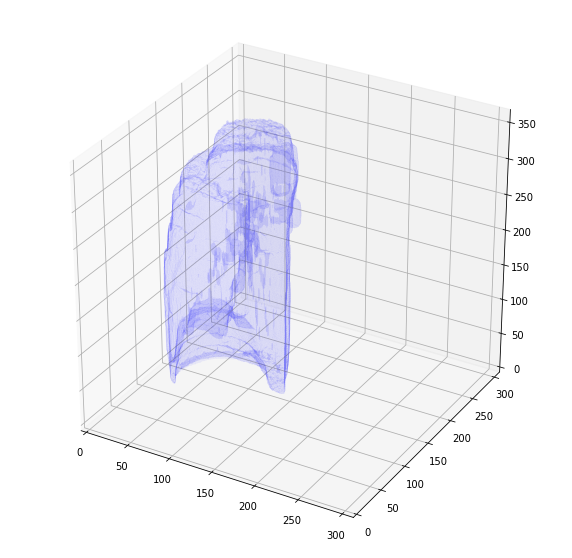

In [31]:
plot_3d(segmented_lungs, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  


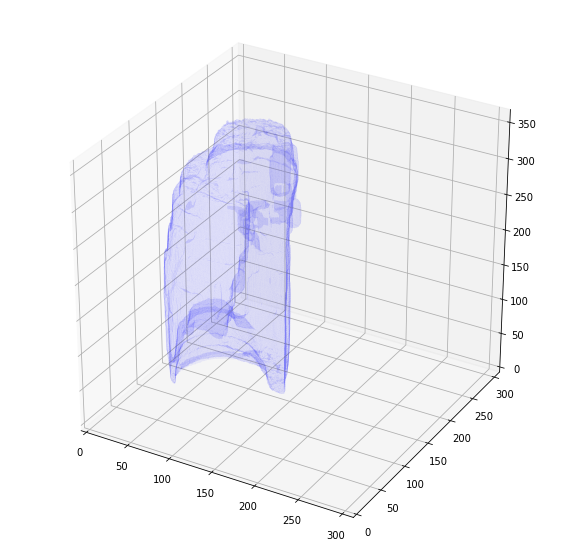

In [32]:
plot_3d(segmented_lungs_fill, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  


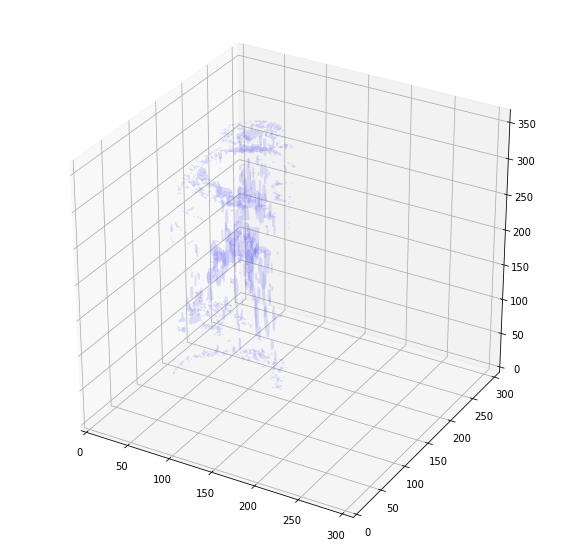

In [33]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

Applying Watershed Algorithm

In [34]:
test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[1])
test_patient_images = get_pixels_hu(test_patient_scans)

Original Slice


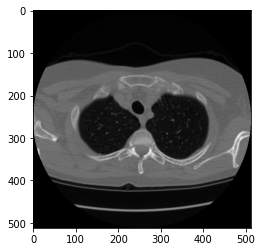

In [36]:
print ("Original Slice")
plt.imshow(test_patient_images[1], cmap='gray')
plt.show()

Internal Marker


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


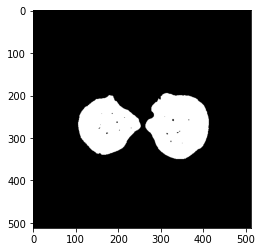

External Marker


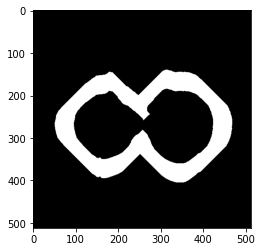

Watershed Marker


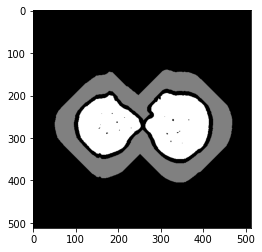

In [38]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[1])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

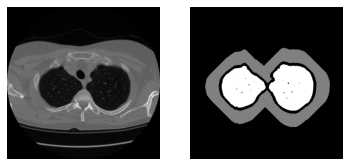

In [40]:
plt.subplot(121)
plt.imshow(test_patient_images[1],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_patient_watershed,cmap = 'gray')
plt.axis('off')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Lung Nodule


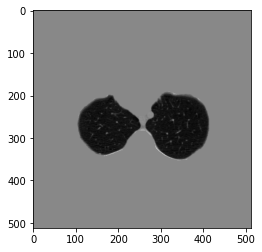

Sobel Gradient


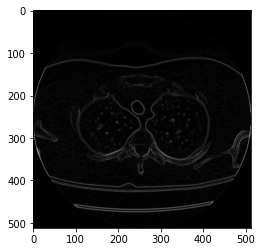

Watershed Image


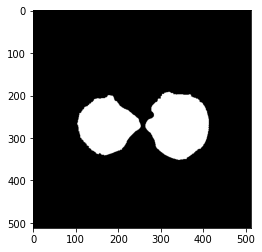

Outline after reinclusion


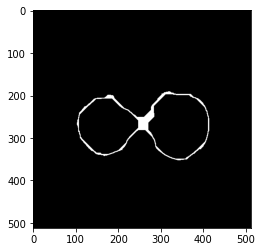

Lungfilter after closing


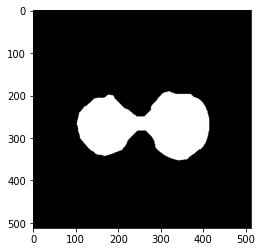

Segmented Lung


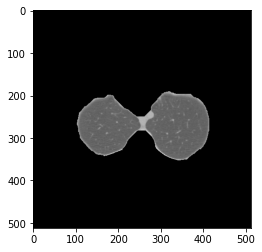

In [42]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))

    
    return segmented, lung_nodule, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, lung_nodule, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[1])

print ("Lung Nodule")
plt.imshow(lung_nodule, cmap='gray')
plt.show()
print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()


(-0.5, 511.5, 511.5, -0.5)

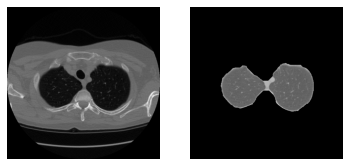

In [43]:

plt.subplot(121)
plt.imshow(test_patient_images[1],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_segmented,cmap = 'gray')
plt.axis('off')

In [44]:
test_segmented.shape

(512, 512)

Preparation for classifier


In [45]:
labels_df = pd.read_csv('/content/drive/My Drive/lungcancer/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [50]:
from pathlib import Path
for patient in patients[:1]:
    label = labels_df.at[(patient, 'cancer')]
    path = INPUT_FOLDER +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force=True) for s in ds]
    #slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])
    print(slices[0].PatientID)
    print('len of ds is ',len(ds))
    print(labels_df.at[(str(slices[0].PatientID), 'cancer')])

KeyError: ignored

In [ ]:
data = []
labels = []
print('*'*30)
print("data in converting.......")
print('*'*30)
j = 1
for patient in patients:
    test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[j])
    test_patient_images = get_pixels_hu(test_patient_scans)
    path = INPUT_FOLDER +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force=True) for s in ds]
    print("patient_number_{}".format(j))
    i = 0
    for s in slices:
        try:
          i += 1
          if i in range(0,50):
            continue
          #taking 100 slices from each patient
          elif i in range(50, 150):
            img = test_patient_images[i]
            seg_img = seperate_lungs(img)[0]
            new_img = np.expand_dims(seg_img,axis = -1)
            label = labels_df.at[(str(s.PatientID), 'cancer')]
            data.append(new_img)
            labels.append(label)
        
            print("converted image is : "+str(len(labels)))
          else:
            break
        except IndexError:
          continue
    j += 1
        

print("Done")

******************************
data in converting.......
******************************
patient_number_1
converted image is : 1
converted image is : 2
converted image is : 3
converted image is : 4
converted image is : 5
converted image is : 6
converted image is : 7
converted image is : 8
converted image is : 9
converted image is : 10
converted image is : 11
converted image is : 12
converted image is : 13
converted image is : 14
converted image is : 15
converted image is : 16
converted image is : 17
converted image is : 18
converted image is : 19
converted image is : 20
converted image is : 21
converted image is : 22
converted image is : 23
converted image is : 24
converted image is : 25
converted image is : 26
converted image is : 27
converted image is : 28
converted image is : 29
converted image is : 30
converted image is : 31
converted image is : 32
converted image is : 33
converted image is : 34
converted image is : 35
converted image is : 36
converted image is : 37
converted image 

In [ ]:
print(len(data))
#print(len(ids))# both lists, with columns specified 
print(len(labels))

In [ ]:
data_new = np.array(data)
data_new.shape

In [ ]:
labels_new = np.array(labels)
labels_new.shape

In [ ]:
from numpy import save
print("saving data")
save("/content/drive/My Drive/lungcancer/data_4.npy",data_new)
print("saving labels")
save("/content/drive/My Drive/lungcancer/labels_4.npy",labels_new)

In [ ]:
from numpy import load
print("loading data")
data = load("/content/drive/My Drive/lungcancer/data_4.npy")
print("loading labels")
labels = load("/content/drive/My Drive/lungcancer/labels_4.npy")

In [ ]:
print(data.shape)
print(labels.shape)

In [ ]:
data_preview = data[:, :, :, 0]

In [ ]:
plt.imshow(data_preview[100],cmap = 'gray')

In [ ]:
labels[100]